#  ACO

In [61]:
import pandas as pd
import numpy as np
import time
import random

# =============================================================================
# 1. CONFIGURACIÓN
# =============================================================================
ARCHIVO_EXCEL = 'matriz_distancias_tsp.xlsx'
TAMANOS_REDES = [100, 150, 200]  # Tamaños solicitados
CANTIDAD_POR_TAMANO = 10          # Cuántas redes de cada tamaño quieres probar
SEED = 42                        # Para resultados reproducibles

# Parámetros ACO (Ajustados para rendimiento)
N_ANTS = 20
N_ITER = 150
ALPHA = 1.0
BETA = 2.0
RHO = 0.05
Q = 100

random.seed(SEED)
np.random.seed(SEED)

# =============================================================================
# 2. PROCESAMIENTO DE DATOS (MÉTODO ROBUSTO)
# =============================================================================
def cargar_y_normalizar_matriz(filepath):
    print(f"📂 Cargando archivo: {filepath} ...")
    try:
        df = pd.read_excel(filepath, header=None, index_col=None)
        D = df.values.astype(float)
    except Exception as e:
        print(f"❌ Error al cargar Excel: {e}")
        return None

    print(f"   Dimensión original: {D.shape}")

    # 1. Rellenar diagonales con 0
    np.fill_diagonal(D, 0)

    # 2. Hacer simétrica (Promedio de ida y vuelta para evitar inconsistencias)
    D = (D + D.T) / 2

    # 3. Manejo de NaNs (Asumir distancia muy grande si falta dato)
    max_val = np.nanmax(D) if not np.isnan(D).all() else 1000
    D = np.nan_to_num(D, nan=max_val)

    # 4. Limpieza de Outliers (Percentil 99)
    # Esto evita que un valor gigante (ej. 999999) arruine la escala
    perc99 = np.percentile(D, 99)
    D[D > perc99] = perc99

    # 5. Normalización a escala [0, 100]
    # Esto es CRUCIAL para que alpha y beta funcionen bien
    if D.max() != 0:
        D = (D / D.max()) * 100

    # 6. Evitar distancias 0 fuera de la diagonal (división por cero en heurística)
    # Reemplazamos 0s (no diagonal) por un valor pequeño (0.01)
    mask_zero = (D < 0.01) & (np.eye(D.shape[0]) == 0)
    D[mask_zero] = 0.01

    print("✅ Matriz maestra normalizada y limpiada (Escala 0-100).")
    return D

def generar_lotes_redes(matriz_maestra, sizes, n_per_size):
    """Genera diccionarios con submatrices listas para el algoritmo"""
    lote = []
    total_nodos = matriz_maestra.shape[0]

    for s in sizes:
        if s > total_nodos:
            print(f"⚠️ Saltando tamaño {s}: La matriz solo tiene {total_nodos} nodos.")
            continue

        for i in range(n_per_size):
            # Selección aleatoria de índices reales
            indices_reales = sorted(random.sample(range(total_nodos), s))

            # Extraer submatriz usando numpy slicing
            submatriz = matriz_maestra[np.ix_(indices_reales, indices_reales)]

            lote.append({
                "id_interno": f"{s}_nodos_v{i+1}",
                "n_nodos": s,
                "indices_reales": indices_reales, # Para saber qué nodos del Excel son
                "matriz_dist": submatriz
            })
    return lote

# =============================================================================
# 3. ALGORITMO ACO (VECTORIZADO Y RÁPIDO)
# =============================================================================
def run_aco_tsp(distance_matrix):
    n = distance_matrix.shape[0]
    tau = np.ones((n, n)) # Feromonas

    # Pre-calcular Heurística (1/d) una sola vez
    with np.errstate(divide='ignore'):
        eta = 1.0 / distance_matrix
    np.fill_diagonal(eta, 0) # Diagonal a 0

    mejor_tour = None
    mejor_distancia = float("inf")

    start_time = time.time()

    for _ in range(N_ITER):
        tours = []
        distancias = []

        # Construcción de soluciones
        for _ in range(N_ANTS):
            tour = [0]
            no_visitados = set(range(1, n))
            actual = 0

            while no_visitados:
                opciones = list(no_visitados)

                # --- Lógica Vectorizada ---
                feromona = tau[actual, opciones]
                heuristica = eta[actual, opciones]

                # Probabilidad = tau^alpha * eta^beta
                numeradores = (feromona ** ALPHA) * (heuristica ** BETA)
                suma = numeradores.sum()

                if suma > 0:
                    probs = numeradores / suma
                else:
                    probs = np.ones(len(opciones)) / len(opciones)

                # Selección Ruleta
                siguiente = np.random.choice(opciones, p=probs)

                tour.append(siguiente)
                no_visitados.remove(siguiente)
                actual = siguiente

            tour.append(0) # Retorno al inicio

            # Calcular costo del tour
            d = 0
            for i in range(len(tour)-1):
                d += distance_matrix[tour[i], tour[i+1]]

            tours.append(tour)
            distancias.append(d)

            if d < mejor_distancia:
                mejor_distancia = d
                mejor_tour = tour[:]

        # Actualización de Feromonas
        tau *= (1 - RHO) # Evaporación global

        for t, d in zip(tours, distancias):
            if d > 0:
                dt = Q / d
                for k in range(len(t)-1):
                    tau[t[k], t[k+1]] += dt

    elapsed = time.time() - start_time
    return mejor_tour, mejor_distancia, elapsed

# =============================================================================
# 4. EJECUCIÓN PRINCIPAL
# =============================================================================

# A) Cargar Matriz
matriz_global = cargar_y_normalizar_matriz(ARCHIVO_EXCEL)

if matriz_global is not None:

    # B) Generar Redes
    print(f"\n⚙️ Generando redes de tamaños {TAMANOS_REDES}...")
    redes_a_procesar = generar_lotes_redes(matriz_global, TAMANOS_REDES, CANTIDAD_POR_TAMANO)
    print(f"   Total de redes generadas: {len(redes_a_procesar)}")

    resultados = []

    # C) Ejecutar Algoritmo
    print(f"\n🚀 INICIANDO EJECUCIÓN ACO ({N_ITER} iteraciones por red)\n")
    print(f"{'ID RED':<15} | {'NODOS':<6} | {'DISTANCIA':<10} | {'TIEMPO':<8}")
    print("-" * 50)

    for red in redes_a_procesar:
        # Ejecutar ACO
        tour_indices_locales, dist, tiempo = run_aco_tsp(red['matriz_dist'])

        # Convertir índices locales (0,1,2...) a los del Excel original (ej. 5, 88, 120)
        tour_indices_excel = [red['indices_reales'][i] for i in tour_indices_locales]

        print(f"{red['id_interno']:<15} | {red['n_nodos']:<6} | {dist:.2f}       | {tiempo:.2f}s")

        resultados.append({
            "Tamaño": red['n_nodos'],
            "Distancia": dist,
            "Tiempo": tiempo,
            "Tour_Excel": tour_indices_excel
        })

    # D) Resumen Final
    df_res = pd.DataFrame(resultados)
    print("\n" + "="*50)
    print("RESUMEN DE PROMEDIOS")
    print("="*50)
    if not df_res.empty:
        print(df_res.groupby("Tamaño")[["Distancia", "Tiempo"]].mean())
    else:
        print("No se generaron resultados.")

    print("\n✅ Proceso Finalizado.")

📂 Cargando archivo: matriz_distancias_tsp.xlsx ...
   Dimensión original: (289, 289)
✅ Matriz maestra normalizada y limpiada (Escala 0-100).

⚙️ Generando redes de tamaños [100, 150, 200]...
   Total de redes generadas: 30

🚀 INICIANDO EJECUCIÓN ACO (150 iteraciones por red)

ID RED          | NODOS  | DISTANCIA  | TIEMPO  
--------------------------------------------------
100_nodos_v1    | 100    | 302.75       | 11.05s
100_nodos_v2    | 100    | 214.59       | 11.26s
100_nodos_v3    | 100    | 202.96       | 10.79s
100_nodos_v4    | 100    | 203.14       | 10.91s
100_nodos_v5    | 100    | 202.92       | 10.92s
100_nodos_v6    | 100    | 215.25       | 10.88s
100_nodos_v7    | 100    | 302.35       | 10.98s
100_nodos_v8    | 100    | 302.71       | 11.05s
100_nodos_v9    | 100    | 202.71       | 10.88s
100_nodos_v10   | 100    | 2.47       | 10.83s
150_nodos_v1    | 150    | 315.65       | 18.25s
150_nodos_v2    | 150    | 27.85       | 18.59s
150_nodos_v3    | 150    | 302.68     

In [63]:
import pandas as pd
import numpy as np
import time
import random

# =============================================================================
# 1. CONFIGURACIÓN (Modificada para 10 redes de 40 nodos)
# =============================================================================
ARCHIVO_EXCEL = 'matriz_distancias_tsp.xlsx'
TAMANOS_REDES = [40]  # Modificado: Solo 40 nodos
CANTIDAD_POR_TAMANO = 10          # Modificado: 10 redes
SEED = 42                        # Para resultados reproducibles

# Parámetros ACO (Ajustados para rendimiento)
N_ANTS = 20
N_ITER = 150
ALPHA = 1.0
BETA = 2.0
RHO = 0.05
Q = 100

random.seed(SEED)
np.random.seed(SEED)

# =============================================================================
# 2. PROCESAMIENTO DE DATOS (MÉTODO ROBUSTO) - Copiado de la celda original
# =============================================================================
def cargar_y_normalizar_matriz(filepath):
    print(f"📂 Cargando archivo: {filepath} ...")
    try:
        df = pd.read_excel(filepath, header=None, index_col=None)
        D = df.values.astype(float)
    except Exception as e:
        print(f"❌ Error al cargar Excel: {e}")
        return None

    print(f"   Dimensión original: {D.shape}")

    # 1. Rellenar diagonales con 0
    np.fill_diagonal(D, 0)

    # 2. Hacer simétrica (Promedio de ida y vuelta para evitar inconsistencias)
    D = (D + D.T) / 2

    # 3. Manejo de NaNs (Asumir distancia muy grande si falta dato)
    max_val = np.nanmax(D) if not np.isnan(D).all() else 1000
    D = np.nan_to_num(D, nan=max_val)

    # 4. Limpieza de Outliers (Percentil 99)
    # Esto evita que un valor gigante (ej. 999999) arruine la escala
    perc99 = np.percentile(D, 99)
    D[D > perc99] = perc99

    # 5. Normalización a escala [0, 100]
    # Esto es CRUCIAL para que alpha y beta funcionen bien
    if D.max() != 0:
        D = (D / D.max()) * 100

    # 6. Evitar distancias 0 fuera de la diagonal (división por cero en heurística)
    # Reemplazamos 0s (no diagonal) por un valor pequeño (0.01)
    mask_zero = (D < 0.01) & (np.eye(D.shape[0]) == 0)
    D[mask_zero] = 0.01

    print("✅ Matriz maestra normalizada y limpiada (Escala 0-100).")
    return D

def generar_lotes_redes(matriz_maestra, sizes, n_per_size):
    """Genera diccionarios con submatrices listas para el algoritmo"""
    lote = []
    total_nodos = matriz_maestra.shape[0]

    for s in sizes:
        if s > total_nodos:
            print(f"⚠️ Saltando tamaño {s}: La matriz solo tiene {total_nodos} nodos.")
            continue

        for i in range(n_per_size):
            # Selección aleatoria de índices reales
            indices_reales = sorted(random.sample(range(total_nodos), s))

            # Extraer submatriz usando numpy slicing
            submatriz = matriz_maestra[np.ix_(indices_reales, indices_reales)]

            lote.append({
                "id_interno": f"{s}_nodos_v{i+1}",
                "n_nodos": s,
                "indices_reales": indices_reales, # Para saber qué nodos del Excel son
                "matriz_dist": submatriz
            })
    return lote

# =============================================================================
# 3. ALGORITMO ACO (VECTORIZADO Y RÁPIDO) - Copiado de la celda original
# =============================================================================
def run_aco_tsp(distance_matrix):
    n = distance_matrix.shape[0]
    tau = np.ones((n, n)) # Feromonas

    # Pre-calcular Heurística (1/d) una sola vez
    with np.errstate(divide='ignore'):
        eta = 1.0 / distance_matrix
    np.fill_diagonal(eta, 0) # Diagonal a 0

    mejor_tour = None
    mejor_distancia = float("inf")
    best_distances_per_iteration = [] # List to store best distance at each iteration

    start_time = time.time()

    for _ in range(N_ITER):
        tours = []
        distancias = []

        # Construcción de soluciones
        for _ in range(N_ANTS):
            tour = [0]
            no_visitados = set(range(1, n))
            actual = 0

            while no_visitados:
                opciones = list(no_visitados)

                # --- Lógica Vectorizada ---
                feromona = tau[actual, opciones]
                heuristica = eta[actual, opciones]

                # Probabilidad = tau^alpha * eta^beta
                numeradores = (feromona ** ALPHA) * (heuristica ** BETA)
                suma = numeradores.sum()

                if suma > 0:
                    probs = numeradores / suma
                else:
                    probs = np.ones(len(opciones)) / len(opciones)

                # Selección Ruleta
                siguiente = np.random.choice(opciones, p=probs)

                tour.append(siguiente)
                no_visitados.remove(siguiente)
                actual = siguiente

            tour.append(0) # Retorno al inicio

            # Calcular costo del tour
            d = 0
            for i in range(len(tour)-1):
                d += distance_matrix[tour[i], tour[i+1]]

            tours.append(tour)
            distancias.append(d)

            if d < mejor_distancia:
                mejor_distancia = d
                mejor_tour = tour[:]

        best_distances_per_iteration.append(mejor_distancia) # Store best distance of this iteration

        # Actualización de Feromonas
        tau *= (1 - RHO) # Evaporación global

        for t, d in zip(tours, distancias):
            if d > 0:
                dt = Q / d
                for k in range(len(t)-1):
                    tau[t[k], t[k+1]] += dt

    elapsed = time.time() - start_time
    return mejor_tour, mejor_distancia, elapsed, best_distances_per_iteration # Return convergence history

# =============================================================================
# 4. EJECUCIÓN PRINCIPAL - Copiado y ajustado para el nuevo experimento
# =============================================================================

# A) Cargar Matriz
matriz_global = cargar_y_normalizar_matriz(ARCHIVO_EXCEL)

if matriz_global is not None:

    # B) Generar Redes
    print(f"\n⚙️ Generando redes de tamaños {TAMANOS_REDES}...")
    redes_a_procesar = generar_lotes_redes(matriz_global, TAMANOS_REDES, CANTIDAD_POR_TAMANO)
    print(f"   Total de redes generadas: {len(redes_a_procesar)}")

    resultados = []

    # C) Ejecutar Algoritmo
    print(f"\n🚀 INICIANDO EJECUCIÓN ACO ({N_ITER} iteraciones por red)\n")
    print(f"{'ID RED':<15} | {'NODOS':<6} | {'DISTANCIA':<10} | {'TIEMPO':<8}")
    print("-" * 50)

    for red in redes_a_procesar:
        # Ejecutar ACO
        tour_indices_locales, dist, tiempo, conv_history = run_aco_tsp(red['matriz_dist'])

        # Convertir índices locales (0,1,2...) a los del Excel original (ej. 5, 88, 120)
        tour_indices_excel = [red['indices_reales'][i] for i in tour_indices_locales]

        print(f"{red['id_interno']:<15} | {red['n_nodos']:<6} | {dist:.2f}       | {tiempo:.2f}s")

        resultados.append({
            "Tamaño": red['n_nodos'],
            "Distancia": dist,
            "Tiempo": tiempo,
            "Tour_Excel": tour_indices_excel,
            "Convergence_History": conv_history # Store convergence history for this run
        })

    # D) Resumen Final
    df_res = pd.DataFrame(resultados)
    print("\n" + "="*50)
    print("RESUMEN DE PROMEDIOS")
    print("="*50)
    if not df_res.empty:
        print(df_res.groupby("Tamaño")[["Distancia", "Tiempo"]].mean())
    else:
        print("No se generaron resultados.")

    print("\n✅ Proceso Finalizado.")

📂 Cargando archivo: matriz_distancias_tsp.xlsx ...
   Dimensión original: (289, 289)
✅ Matriz maestra normalizada y limpiada (Escala 0-100).

⚙️ Generando redes de tamaños [40]...
   Total de redes generadas: 10

🚀 INICIANDO EJECUCIÓN ACO (150 iteraciones por red)

ID RED          | NODOS  | DISTANCIA  | TIEMPO  
--------------------------------------------------
40_nodos_v1     | 40     | 201.10       | 3.85s
40_nodos_v2     | 40     | 25.58       | 3.59s
40_nodos_v3     | 40     | 1.39       | 4.13s
40_nodos_v4     | 40     | 201.29       | 3.60s
40_nodos_v5     | 40     | 201.69       | 3.56s
40_nodos_v6     | 40     | 201.38       | 4.32s
40_nodos_v7     | 40     | 25.82       | 3.59s
40_nodos_v8     | 40     | 1.50       | 3.58s
40_nodos_v9     | 40     | 1.44       | 4.25s
40_nodos_v10    | 40     | 1.49       | 3.56s

RESUMEN DE PROMEDIOS
        Distancia    Tiempo
Tamaño                     
40      86.268394  3.802645

✅ Proceso Finalizado.


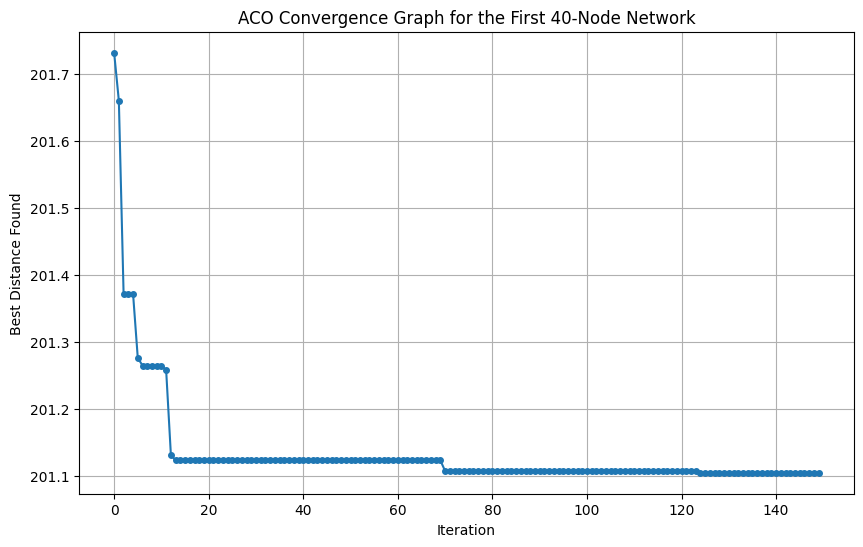

In [64]:
import matplotlib.pyplot as plt

# Assuming df_res (DataFrame of results) is available from the previous cell's execution

# Get the convergence history for the first network (index 0) in df_res
# Check if df_res is not empty and if 'Convergence_History' column exists
if not df_res.empty and 'Convergence_History' in df_res.columns:
    first_network_conv_history = df_res.loc[0, 'Convergence_History']

    plt.figure(figsize=(10, 6))
    plt.plot(first_network_conv_history, marker='o', linestyle='-', markersize=4)
    plt.title('ACO Convergence Graph for the First 40-Node Network')
    plt.xlabel('Iteration')
    plt.ylabel('Best Distance Found')
    plt.grid(True)
    plt.show()
else:
    print("No results DataFrame found or 'Convergence_History' is missing.")
